# 10-12 일원,이원분산분석 연습문제

## #01. 준비작업

### 1. 이원분산분석용 패키지 가져오기:

In [2]:
from hossam import load_data
from pandas import melt, DataFrame
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
from math import sqrt

# 가정 확인을 위한 라이브러리:
from scipy.stats import t, normaltest, bartlett, levene

# 분산분석을 위한 라이브러리:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import anova, welch_anova

# 사후검정을 위한 라이브러리:
from pingouin import pairwise_tukey, pairwise_tests, pairwise_gameshowell

### 2. 그래프 초기화:

In [3]:
my_dpi = 200  # 이미지 선명도 (100~300)
font_path = r"\Users\itwill\OneDrive\문서\학원수업\NotoSansKR-Regular.ttf"  # 한글을 지원하는 폰트 파일의 경로
fm.fontManager.addfont(font_path)      # 폰트 글꼴을 시스템에 등록함
font_prop = fm.FontProperties(fname = font_path)    # 폰트 속성을 읽어옴
font_name = font_prop.get_name()    # 읽어온 속성에서 폰트의 이름만 추출

plt.rcParams['font.family'] = font_name # 그래프에 한글폰트 적용
plt.rcParams['font.size'] = 12          # 기본 폰트 크기
plt.rcParams['axes.unicode_minus'] = False  
    # 그래프에 마이너스 깨짐 방지 (한글 환경에선 필수)

## #02. 각 문제 별 데이터 로딩, 분석 수행

## 문제 1:

`poisons` 데이터셋은 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터이다.

사용된 독극물 종류와 치료 유형에 유의미한 차이가 있는지 분석하라.

### 1. 데이터 로딩하기:

In [4]:
origin = load_data('poisons')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/poisons.xlsx
[desc] 독극물 종류별로 동물의 생존시간을 기록한 실험 데이터 (출처: 방송통신대학교 통계학 개론)

field    description
-------  ------------------
time     동물의 생존시간
poison   사용된 독극물 종류
treat    사용되는 치료 유형


===== 데이터 크기 확인 =====
데이터셋 크기: (360, 3)
열 갯수: 3
행 갯수: 360

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    360 non-null    float64
 1   poison  360 non-null    object 
 2   treat   360 non-null    object 
dtypes: float64(1), object(2)
memory usage: 8.6+ KB
None


,time,poison,treat
0,3.8,P1,T1
1,2.7,P1,T1
2,1.7,P1,T1
3,2.2,P1,T1
4,0.7,P1,T1


명목형 2개, 수치형 1개 => 이원분산분석 ㄱㄱ 

### 2. 그래프 시각화:

#### (1) 독극물 종류 별 치료유형에 따른 동물 생존시간:

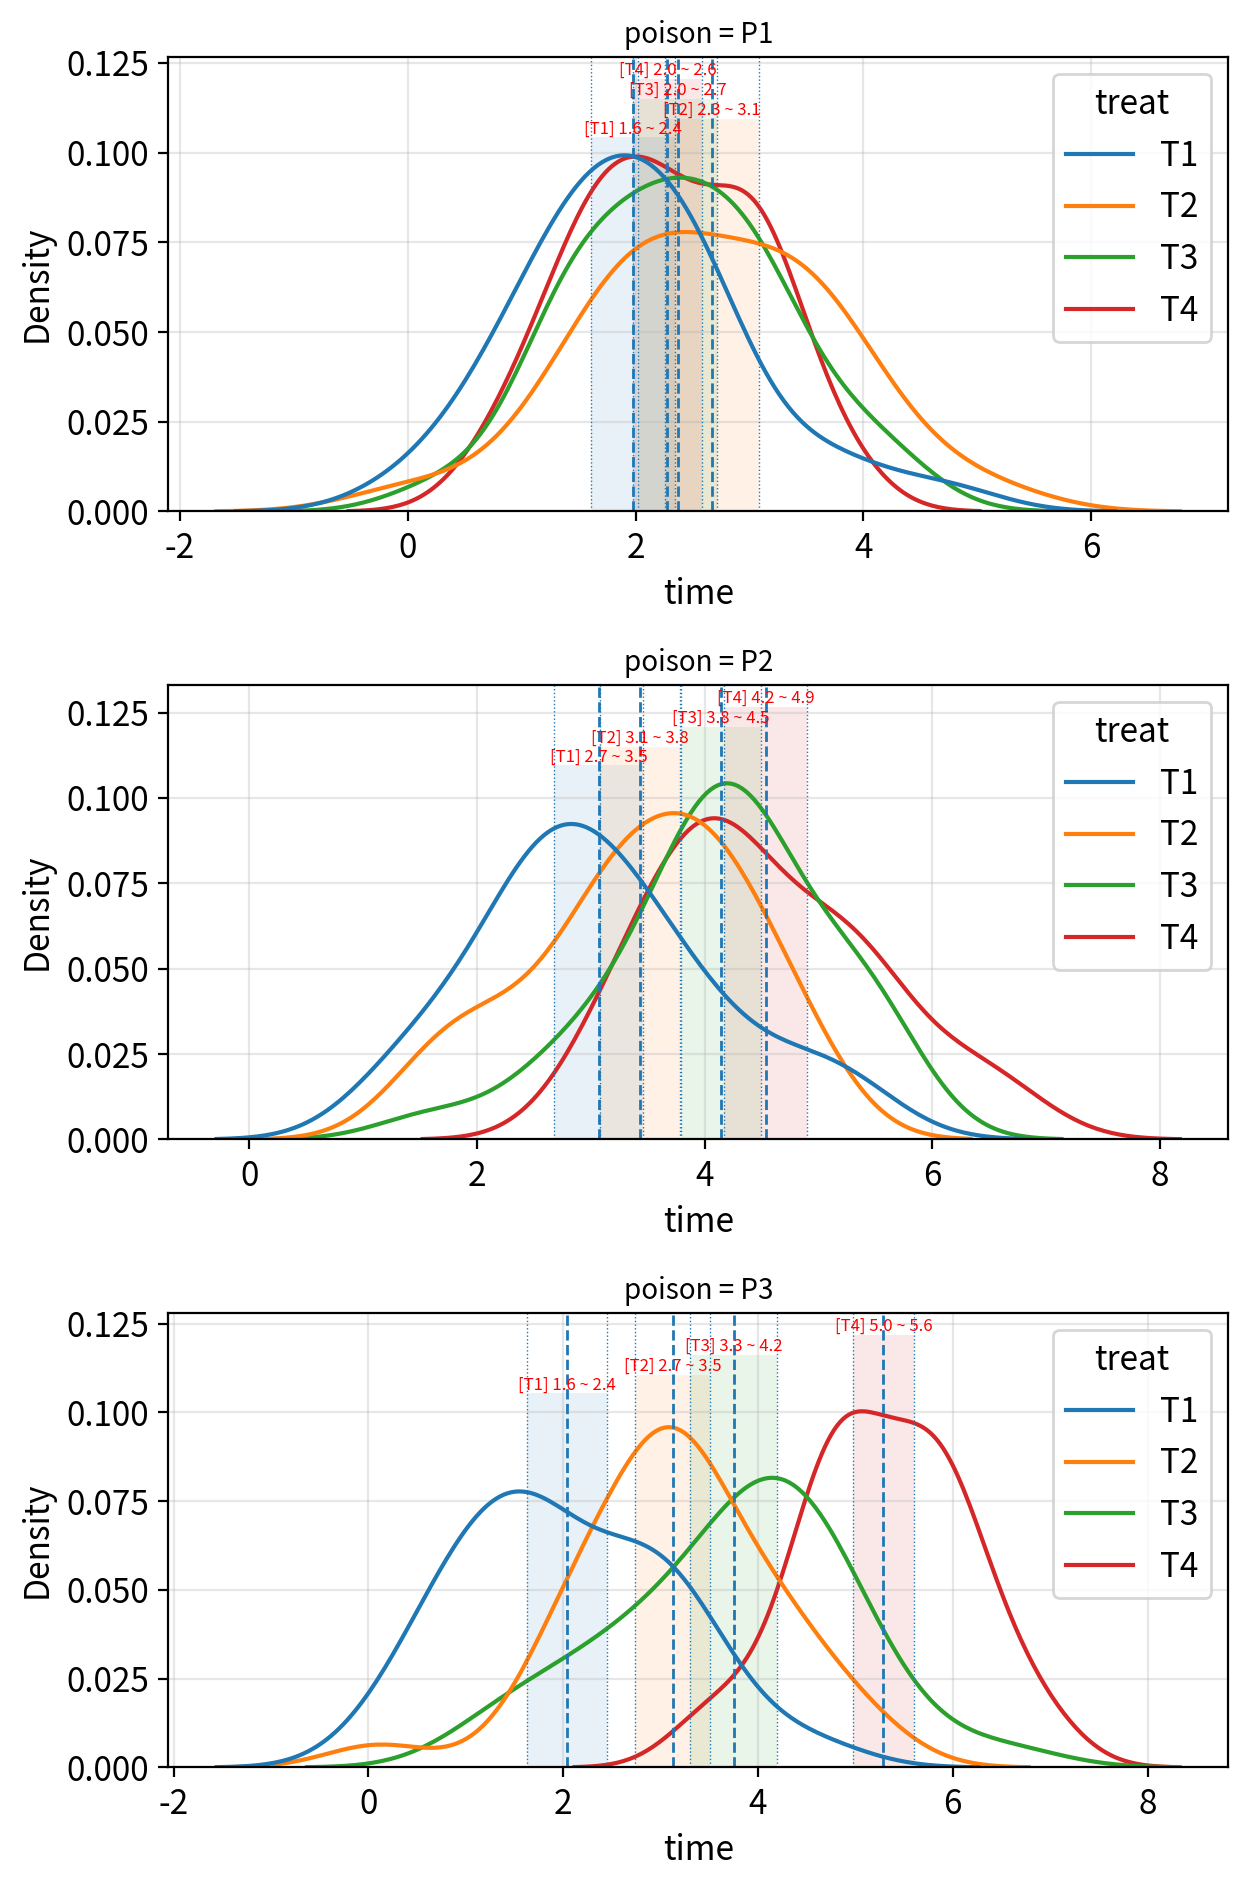

In [5]:
# 확인할 데이터 필드 (수치형):
field = 'time'
# 범주형 필드1:
group_field = 'poison'
# 범주형 필드2 (hue):
hue_field = 'treat'

# 시각화 할 필드만 원본데이터에서 추출:
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

#### (2) 치료유형 별 독극물에 따른 동물 생존시간:

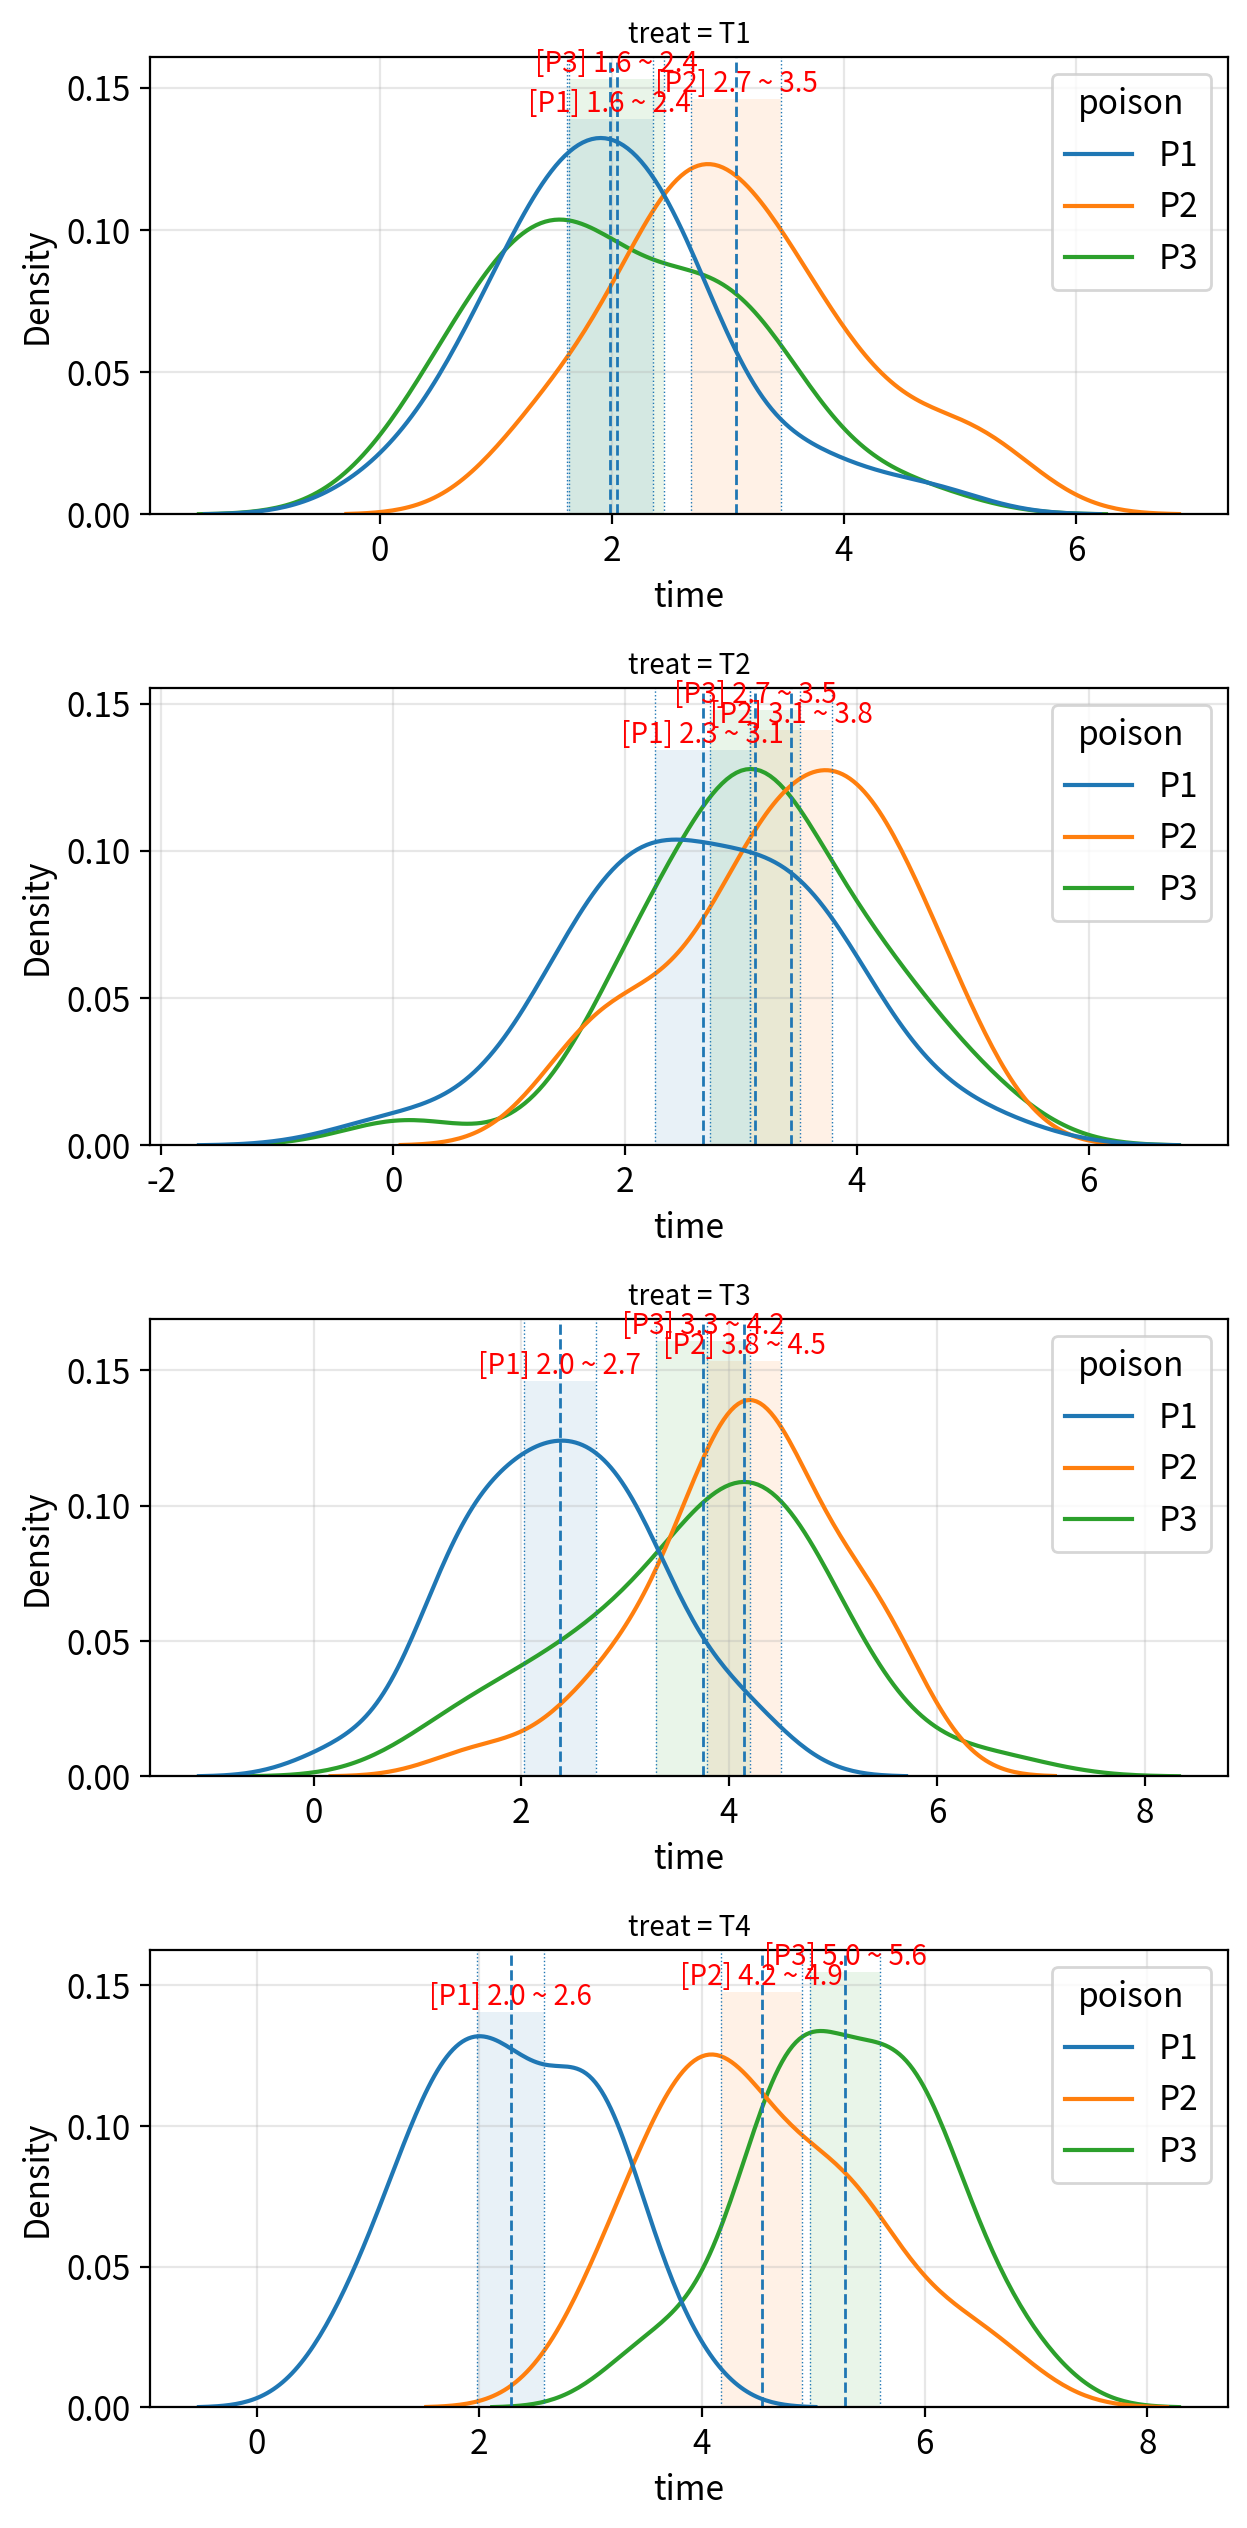

In [6]:
# 확인할 데이터 필드 (수치형):
field = 'time'
# 범주형 필드1:
group_field = 'treat'
# 범주형 필드2 (hue):
hue_field = 'poison'

# 시각화 할 필드만 원본데이터에서 추출:
data = origin[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 10, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

### 3. 가설검정의 가정 확인하기:

In [7]:
data = origin.copy()
xname = ['poison', 'treat']  # 범주형 독립변수 2개
yname = 'time'          # 수치형 종속변수 1개

u1 = data[xname[0]].unique() # 명목형변수1의 수준들 종류
u2 = data[xname[1]].unique() # 명목형변수2의 수준들 종류
equal_var_fields = []        # 충족한 등분산성 조건 저장용 
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "fields": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

# 등분산성 검정법 선택:
if normal_dist:
    n = "Bartlett" # : 정규성 충족할 때
    s, p = bartlett(*equal_var_fields) # 모든 컬럼의 데이터 한번에
else:
    n = "Levene's" # :정규성 충족 못할 때
    s, p = levene(*equal_var_fields, 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": n,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
"P1, T1",3.660816,0.160348,True
"P1, T2",0.266462,0.875263,True
"P1, T3",0.014374,0.992839,True
"P1, T4",1.476194,0.478023,True
"P2, T1",1.112279,0.573418,True
"P2, T2",1.509951,0.470022,True
"P2, T3",2.802084,0.246340,True
"P2, T4",1.662054,0.435602,True
"P3, T1",0.837473,0.657878,True


: 두 범주로 나올 수 있는 모든 경우의 수 수준들이 정규성, 등분산성 충족

### 4. 이원분산분석 수행 후, 결과표, 문장 출력하기:

In [8]:
xname = ['poison', 'treat']
yname = 'time'
data = origin[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"→ {source}효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source}효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,poison,148.976389,2,74.488194,74.722166,1.002877e-27,0.300424
1,treat,131.260972,3,43.753657,43.891090,4.430485e-24,0.274506
2,poison * treat,81.381611,6,13.563602,13.606206,6.938981e-14,0.190014
3,Residual,346.910333,348,0.996869,NaN,NaN,NaN


→ poison효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ treat효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ poison * treat효과는 유의함. (대립가설 채택: p ≤ 0.05)
→ Residual효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


Note: poison * treat 콜라보 효과가 유의하다고 나옴. (대립가설 채택: p ≤ 0.05)

### 5. 사후검정:

In [9]:
xname = ['poison', 'treat']  # 명목형 독립변수 2개
yname = 'time'          # 수치형 종속변수 1개
data = origin[xname + [yname]]

levels = {}           # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식의 결과 만들기 위해:
for factor in xname:                     # 명목변수 하나씩 꺼냄
    level_count = data[factor].nunique()# 꺼낸 변수의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장

pvals = {}            # 빈 딕셔너리 만들기
# 예: {'water': 1.3e-20, 'sun': 2.01e-17, 'water*sun': 0.105}:
for index, row in pg_anova.iterrows():  # 행 하나씩 꺼냄
    source_name = row['Source']         # 명목변수 이름
    p_value = row['p-unc']              # 각 명목변수의 p-value
    pvals[source_name] = p_value        # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안함")
        continue

    print(f"- 주효과 유의함 (p={p_val:.3g}) → 사후검정 수행")

    # 결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
    # 얼마나? -> 사후검정 ㄱㄱ
    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리:
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의함 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 불필요")


[poison]
- 주효과 유의함 (p=1e-27) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,P1,P2,2.325000,3.795833,-1.470833,0.161626,-9.100235,5.107026e-14,-1.388884
1,P1,P3,2.325000,3.550000,-1.225000,0.161626,-7.579233,9.585666e-13,-0.931693
2,P2,P3,3.795833,3.550000,0.245833,0.161626,1.521002,2.822579e-01,0.179210



[treat]
- 주효과 유의함 (p=4.43e-24) → 사후검정 수행
 · Tukey HSD 사용 (등분산 충족)


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,T1,T2,2.363333,3.075556,-0.712222,0.189827,-3.751957,1.168920e-03,-0.639750
1,T1,T3,2.363333,3.421111,-1.057778,0.189827,-5.572330,2.971230e-07,-0.867932
2,T1,T4,2.363333,4.034444,-1.671111,0.189827,-8.803345,6.006307e-14,-1.220199
3,T2,T3,3.075556,3.421111,-0.345556,0.189827,-1.820373,2.654092e-01,-0.292572
4,T2,T4,3.075556,4.034444,-0.958889,0.189827,-5.051387,4.181336e-06,-0.717648
5,T3,T4,3.421111,4.034444,-0.613333,0.189827,-3.231015,7.343056e-03,-0.430346



[poison * treat] 상호작용 효과
- 상호작용 유의함 (p=6.94e-14) → 단순주효과 분석 필요


obtained information:
- time: 동물의 생존시간
- poison: 사용된 독극물 종류
- treat: 사용되는 치료 유형
- [poison * treat] 상호작용 효과
  - 상호작용 유의함 (p=6.94e-14) → 단순주효과 분석 필요

====== <민영 사고과정:> ======
- **즉, 독극물 종류 별로 치료의 효과에 영향받는 유형이 다 다르다는 말 아님?**
  - 치료유형에 관계 없이 독극물이 치료시간에 영향을 끼친다는 게 아니라
    - 치료유형별로 독극물 내성이 다르다는 거임 치료시간에 영향 미칠 때
      - 아, 범주 두개 있을 떄 비교하는 관계시각화 해봐야겠다
        - -> lmplot ㄱㄱ?

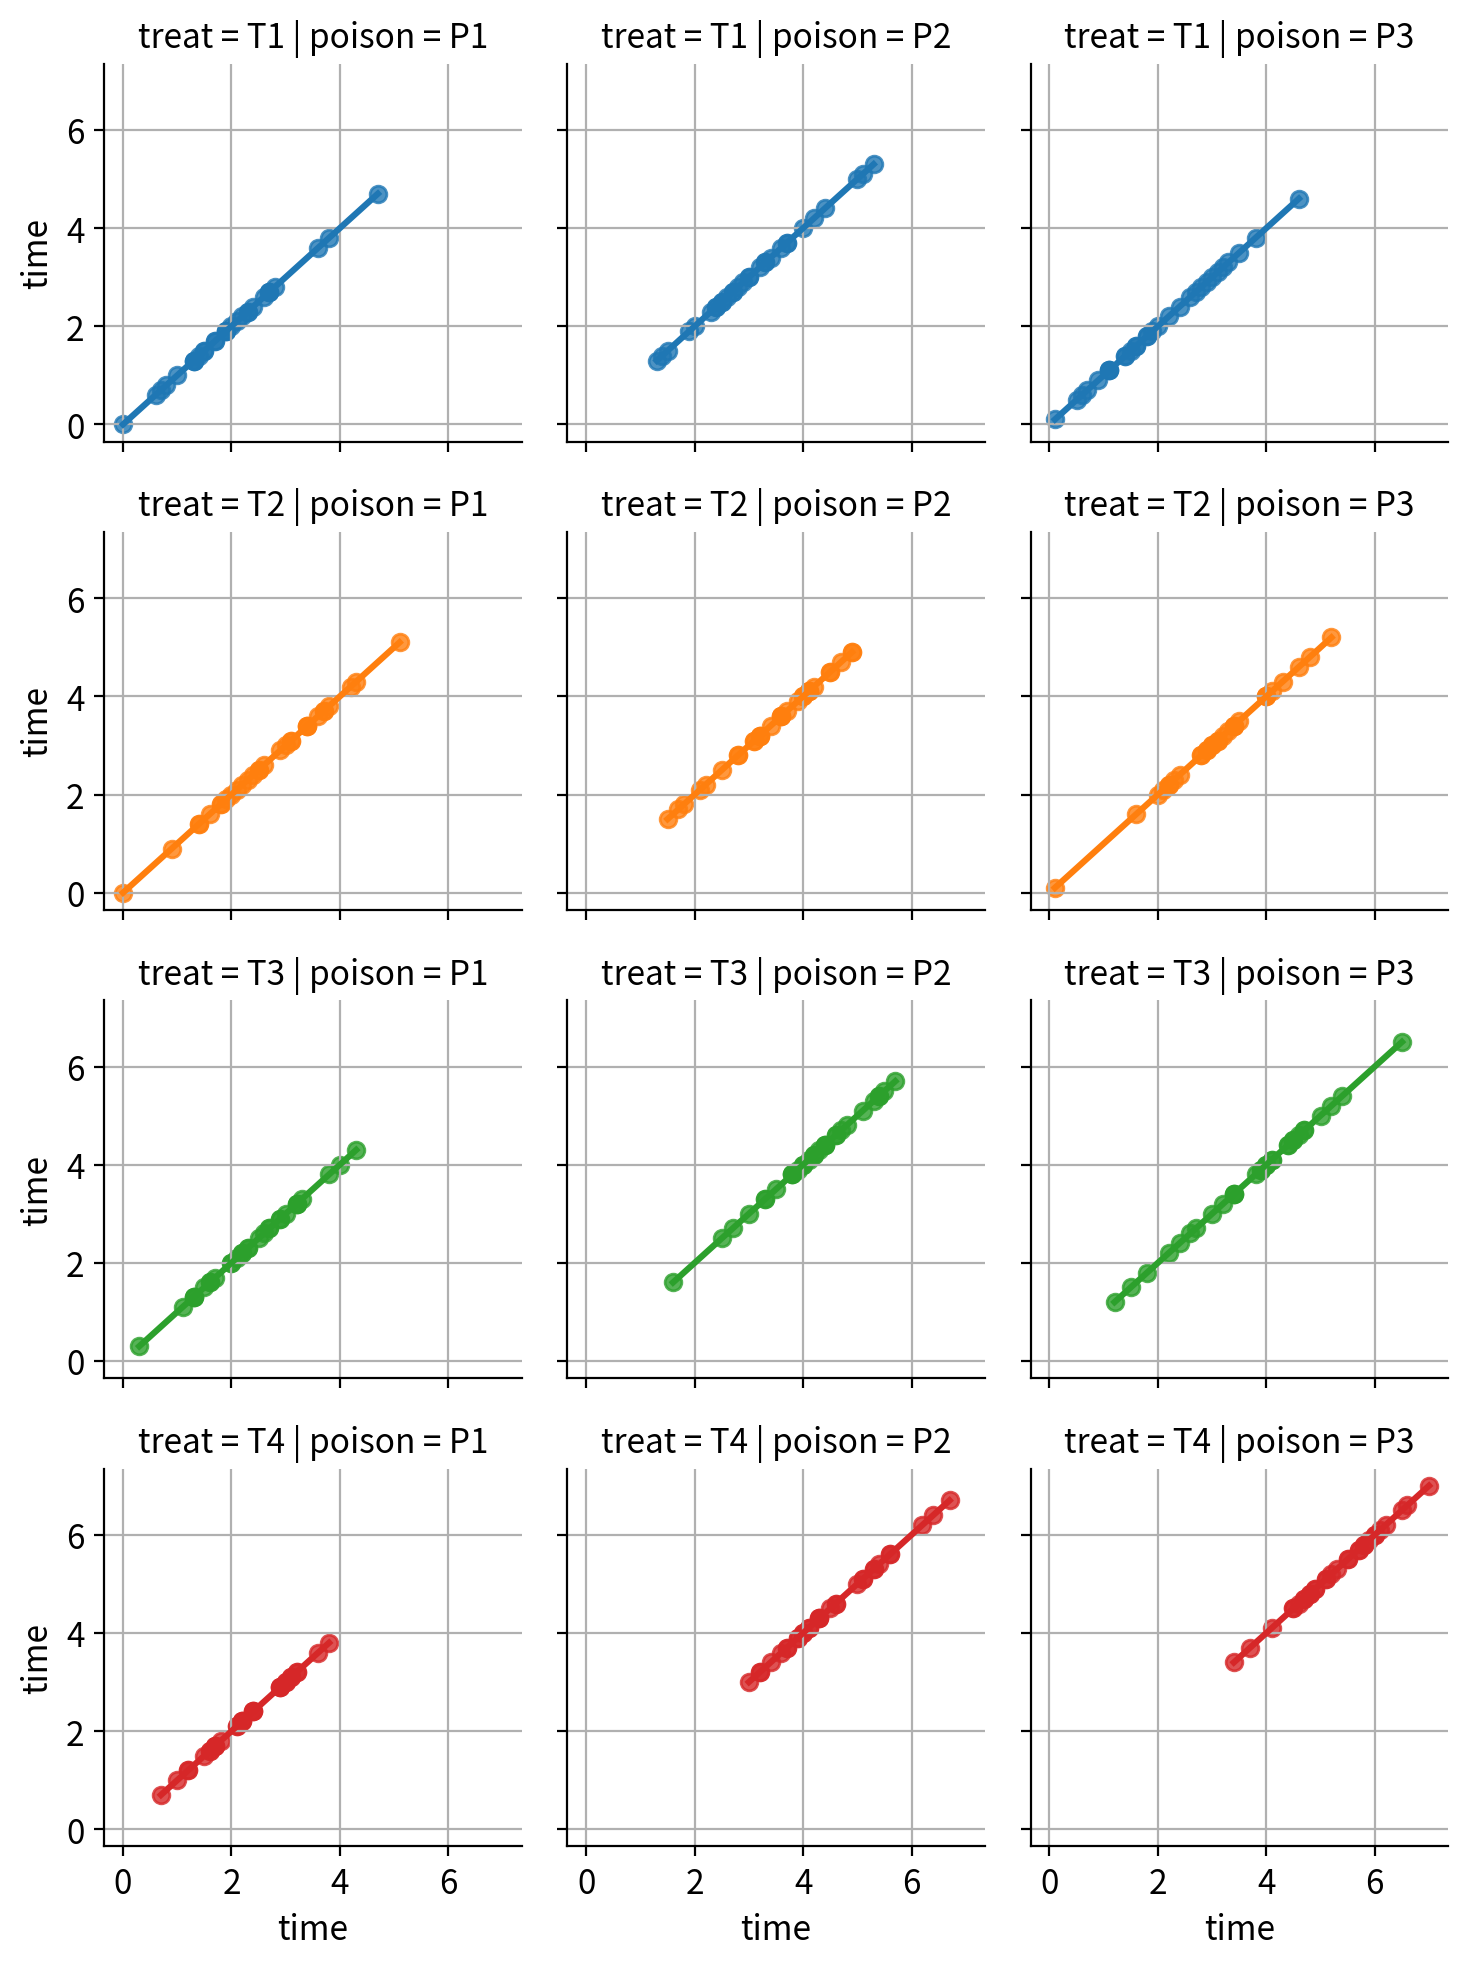

In [10]:
# 1) 그래프 초기화
width_px = 1500             # 그래프 가로 크기
height_px = 2000             # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# 2) Lm Plot 그래프 그리기
# 하위 집단이 여러개 이므로 그래프 꾸미기가 필요
    # -> .lmplot() 메서드로부터 리턴되는 객체 ('g')를 활용해야함

# 한 그래프 안에 다 넣어서 보고자 할 때:
#g = sb.lmplot(data = ✅, hue = '✅', x = '✅', y = '✅')

# hue 별로 개별 그래프 생성 원할 때:
#g = sb.lmplot(data = ✅, hue = '✅', x = '✅', y = '✅',
#              col = '~별로 부분 범주형 변수', col_wrap = '숫자')

# 범주형 변수가 (hue 포함) 두개 이상일 때 행렬 지정:
g = sb.lmplot(data=data, row = 'treat', col='poison',  
              hue='treat', x='time', y='time')
g.fig.set_dpi(my_dpi)
g.fig.set_figwidth(figsize[0])
g.fig.set_figheight(figsize[1])

for ax in g.axes.flatten():
    ax.grid(True)

# 3) 그래프 꾸미기: 
#ax.grid(True)                # 배경, 격자 표시/숨김

# 4) 출력
plt.tight_layout()            # 여백 제거
plt.show()                    # 그래프 화면 출력
plt.close()                   # 그래프 작업 종료

- 치료유형이랑 독극물이 콜라보 해서 생존시간에 영향 준 거 찾음 되자나?
- 그럼 딱 봐도 독극물3가 치료유형들에 다 영향받네 (제일 쪼렙)
- 이유?
  - 독극물1, 2는 치료유형에 상관없는 생존시간 길이
  - 독극물3는 치료유형마다 생존시간 편차 제일 큼?
- 결론:
  - -> 행 분석: 치료유형은 T4가 제일 강력함
  - -> 열 분석: 독성은 P1 독극물이 제일 빡셈 (치료유형에 대한 민감성 제일 낮음, P3가 제일 민감성 높고)

## 문제 2
`tomato` 데이터 셋은 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과이다.

분산분석을 하여 효소 함량에 따라 토마토 모종 성장에 차이가 나는지 검정하라.

In [11]:
origin = load_data('tomato')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/tomato.xlsx
[desc] 효소 성분의 비료가 효소 함량이 증가함에 따라 토마토 모종 포기의 성장에 어떤 영향을 주는지에 대한 실험 결과 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (90, 2)
열 갯수: 2
행 갯수: 90

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   효소함량    90 non-null     int64  
 1   모종성장    90 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 1.5 KB
None


,효소함량,모종성장
0,0,9.5
1,0,10.0
2,0,10.7
3,0,9.0
4,0,12.4


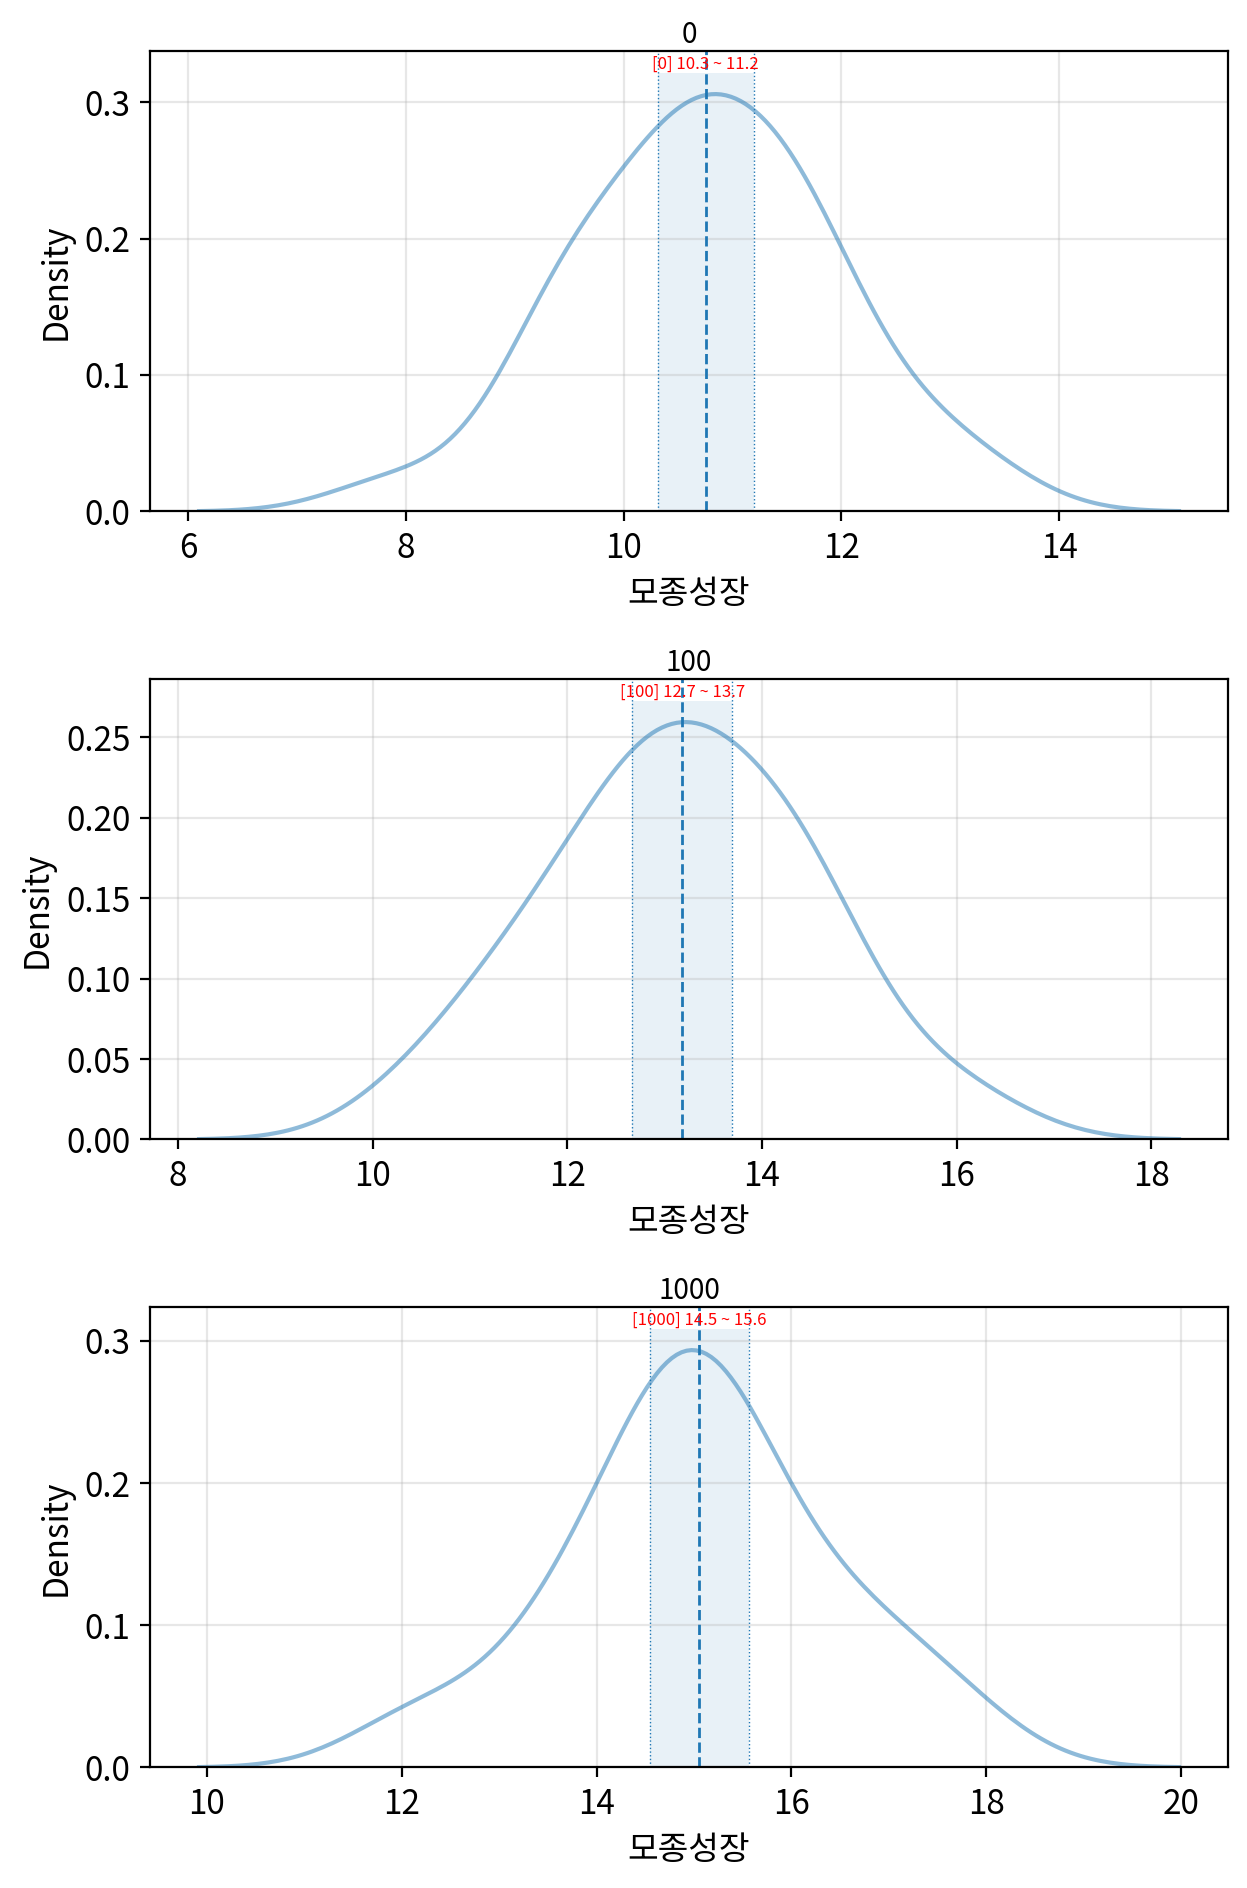

In [12]:
# 확인할 데이터 필드 (수치형):
field = '모종성장'

# 집단 구분용 필드 (범주형, hue):
hue_field = '효소함량'

# 요일 종류: 
hue_values = origin[hue_field].unique()
hue_count = len(hue_values)

# 1) 그래프 초기화 (초기설정, 캔버스(fig)랑 도화지(ax) 준비하기)
width_px = 1280             # 그래프 가로 크기
height_px = 640 * 3         # 그래프 세로 크기
rows = 3                    # 그래프 행 수
cols = 1                    # 그래프 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

for i, v in enumerate(hue_values):
    temp = origin[origin[hue_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, fill=False, ax = ax[i], alpha=0.5)
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title(v, fontsize=10, pad=3)

    # 신뢰구간용 기본변수:
    max = temp[field].max()                        # 최대값
    dof = len(temp[field]) - 1                     # 자유도
    clevel = 0.95                                  # 신뢰수준
    sp_mean = temp[field].mean()                   # 표본평균
    sp_std = temp[field].std(ddof=1) # default: ddof=1   # 표본표준편차
    sp_std_error = sp_std / sqrt(len(temp[field])) # 표본표준오차

    cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

    ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
    ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

    # 신뢰구간 y값, 평균표시:
    ymin, ymax = ax[i].get_ylim()
    ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
    ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

    # 텍스트 그리기 (statAnnotator 기능):
    ax[i].text(x = cmin + (cmax-cmin)/2,
            y=ymax,
            s="[%s] %0.1f ~ %0.1f" % (v, cmin, cmax),
            horizontalalignment = "center",
            verticalalignment = "bottom",
            fontdict = {"size": 6, "color": "red"})

# 4) 출력
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

In [13]:
# hue 별 그룹 생성:
groups = [(name, grp['모종성장']) for name, grp in origin.groupby('효소함량')]
# ↑: pivot table (리스트, 2차월 배열 같은) 만든거임 
    # grping 된 data들
    # ex) [(금, [a, b, c, ..]), (토, [m,n,o,..]), (일, [..])]

report = []
normal_dist = True

for name, series in groups:
    stat, p = normaltest(series)
    ok = p > 0.05
    report.append({
        "fields": name,
        "statistic": stat,
        "p-value": p,
        "result": ok
    })
    normal_dist = normal_dist and ok

# 등분산성 검정법 선택:
    # 정규성 충족할 때 등분산성 검정방법:
if normal_dist:
    test_name = "Bartlett"
    stat, p = bartlett(*[s.values for _, s in groups]) # 모든 컬럼의 데이터 한번에
# 정규성 충족 못할 때 등분산성 검정법:
else:
    test_name = "Levene's"
    stat, p = levene(*[s.values for _, s in groups], 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": test_name,
    "statistic": stat,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
0,0.237689,0.887946,True
100,0.000368,0.999816,True
1000,0.234748,0.889253,True
Bartlett,0.776052,0.678395,True


In [14]:
# 분석할 데이터만 추출:
anova_df = origin[['모종성장', '효소함량']].copy()
#anova_df

# pingouin 패키지 사용:
if equal_var: # : 만약 등분산성 충족하면
    pg_anova = anova(data=anova_df, dv='모종성장', between='효소함량')
else: # : 만약 등분산성 충족 못하면
    pg_anova = welch_anova(data=anova_df, dv='모종성장', between='효소함량')
display(pg_anova)

# 결과 확인:
f_val = pg_anova['F'].iloc[0]
p_val = pg_anova['p-unc'].iloc[0]
"statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(f_val, p_val, "대립" if p_val<=0.05 else "귀무")

,Source,ddof1,ddof2,F,p-unc,np2
0,효소함량,2,87,81.094169,1.318657e-20,0.650866


'statistic: 81.094, p-value: 0.000, 대립가설 채택'

In [15]:
#결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
# 얼마나? -> 사후검정 ㄱㄱ
if equal_var:
    print("=== Tukey HSD ===")
    hoc_df = pairwise_tukey(data=anova_df, dv='모종성장', between='효소함량')
else:
    print("=== Games-Howell ===")
    hoc_df = pairwise_gameshowell(data=anova_df, dv='모종성장', between='효소함량')

hoc_df

=== Tukey HSD ===


,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,0,100,10.753333,13.180000,-2.426667,0.338824,-7.162024,7.228520e-10,-1.867526
1,0,1000,10.753333,15.056667,-4.303333,0.338824,-12.700788,2.220446e-15,-3.315507
2,100,1000,13.180000,15.056667,-1.876667,0.338824,-5.538763,9.517362e-07,-1.350914


**해석:**

# 문제 3
`edu` 데이터 셋은 두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료이다.

이 자료를 이용하여 두 가지 교육방법에 대한 국어와 영어의 효과가 서로 다르다고 할 수 있는지 검정하라. (분석 목적에 맞는 데이터 재배치 과정이 필요합니다.)

In [16]:
origin = load_data('edu')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기: {origin.shape}")
print(f"열 갯수: {origin.shape[1]}")
print(f"행 갯수: {origin.shape[0]}")

print("\n===== 타입 확인 =====")
print(origin.info())

origin.head()

[data] https://data.hossam.kr/data/lab10_/edu.xlsx
[desc] 두 가지 교육방법을 비교하기 위하여 능력이 비슷한 고등학교 학생 22명을 추출하고, 11명씩 두 집단으로 나누어 한 학기 동안 각각의 교육방법으로 교육시킨 후 치른 학기말 시험 성적을 조사한 자료 (출처: 방송통신대학교 통계학 개론)
[!] Cannot read metadata

===== 데이터 크기 확인 =====
데이터셋 크기: (22, 3)
열 갯수: 3
행 갯수: 22

===== 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   교육방법    22 non-null     int64
 1   국어      22 non-null     int64
 2   영어      22 non-null     int64
dtypes: int64(3)
memory usage: 660.0 bytes
None


,교육방법,국어,영어
0,1,65,82
1,1,87,79
2,1,73,85
3,1,79,60
4,1,81,65


### 2. 데이터 전처리:

In [17]:
#origin['교육방법'].unique()
df = melt(origin, id_vars='교육방법',
          value_vars=['국어', '영어'],
          var_name='과목', value_name='성적')
df.head()

,교육방법,과목,성적
0,1,국어,65
1,1,국어,87
2,1,국어,73
3,1,국어,79
4,1,국어,81


### 3. 데이터분포 시각화

#### (1) 과목 별 교육방법에 따른 성적 비교

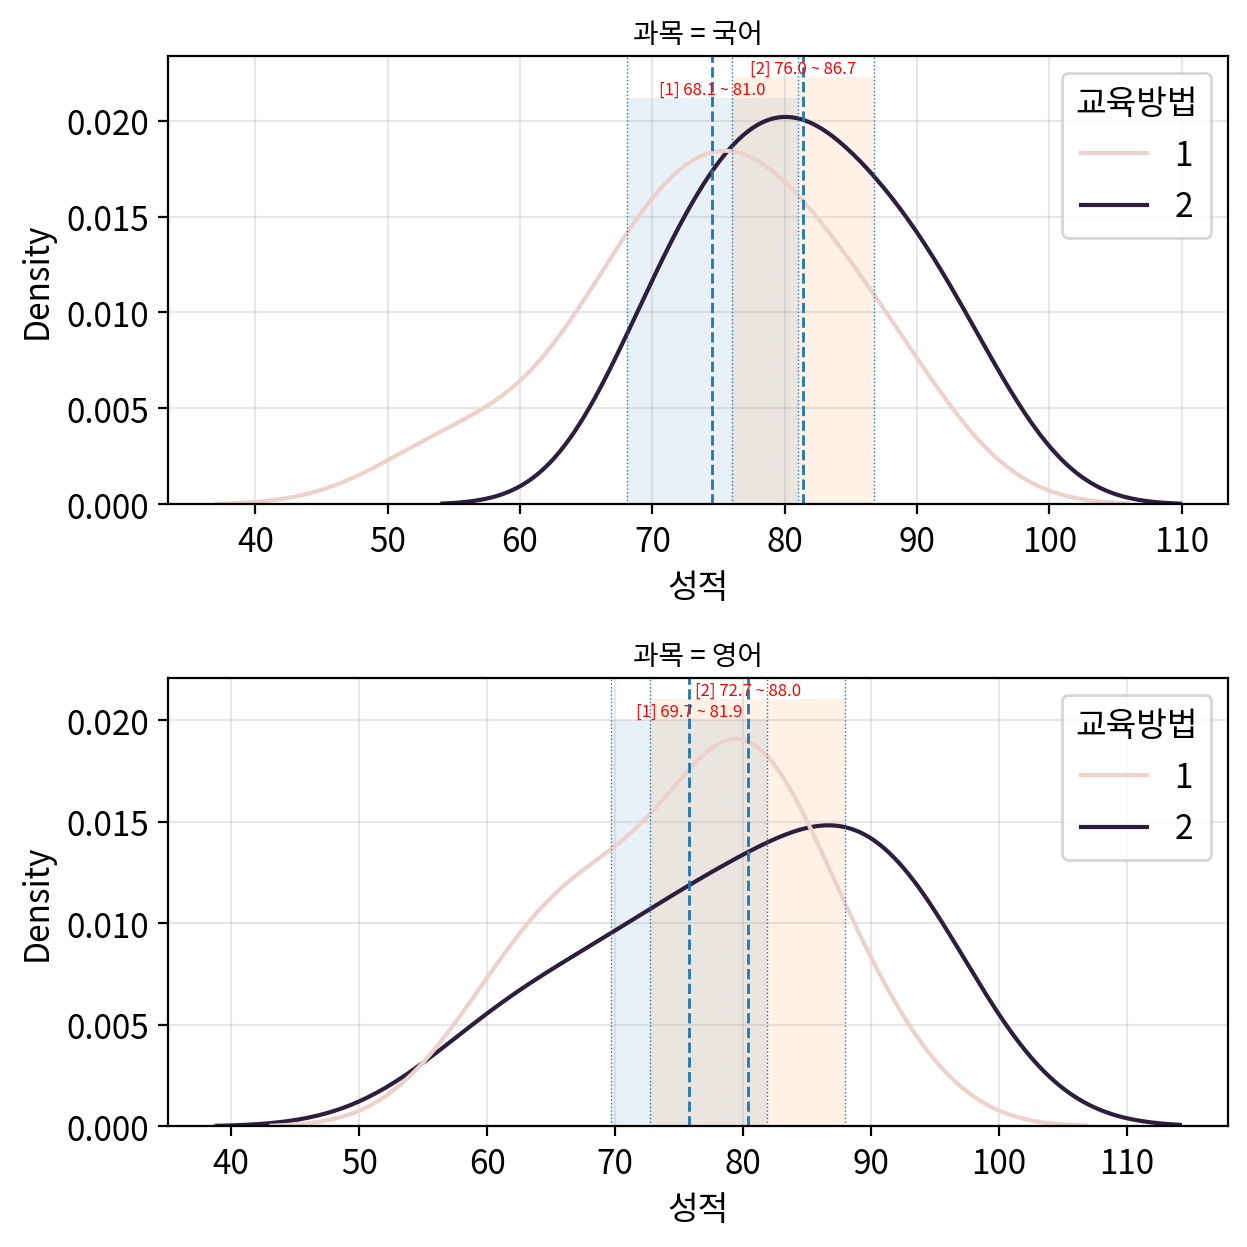

In [18]:
# 확인할 데이터 필드 (수치형):
field = '성적'
# 범주형 필드1:
group_field = '과목'
# 범주형 필드2 (hue):
hue_field = '교육방법'

# 시각화 할 필드만 원본데이터에서 추출:
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

#### (2) 교육방법 별 과목에 따른 성적 비교

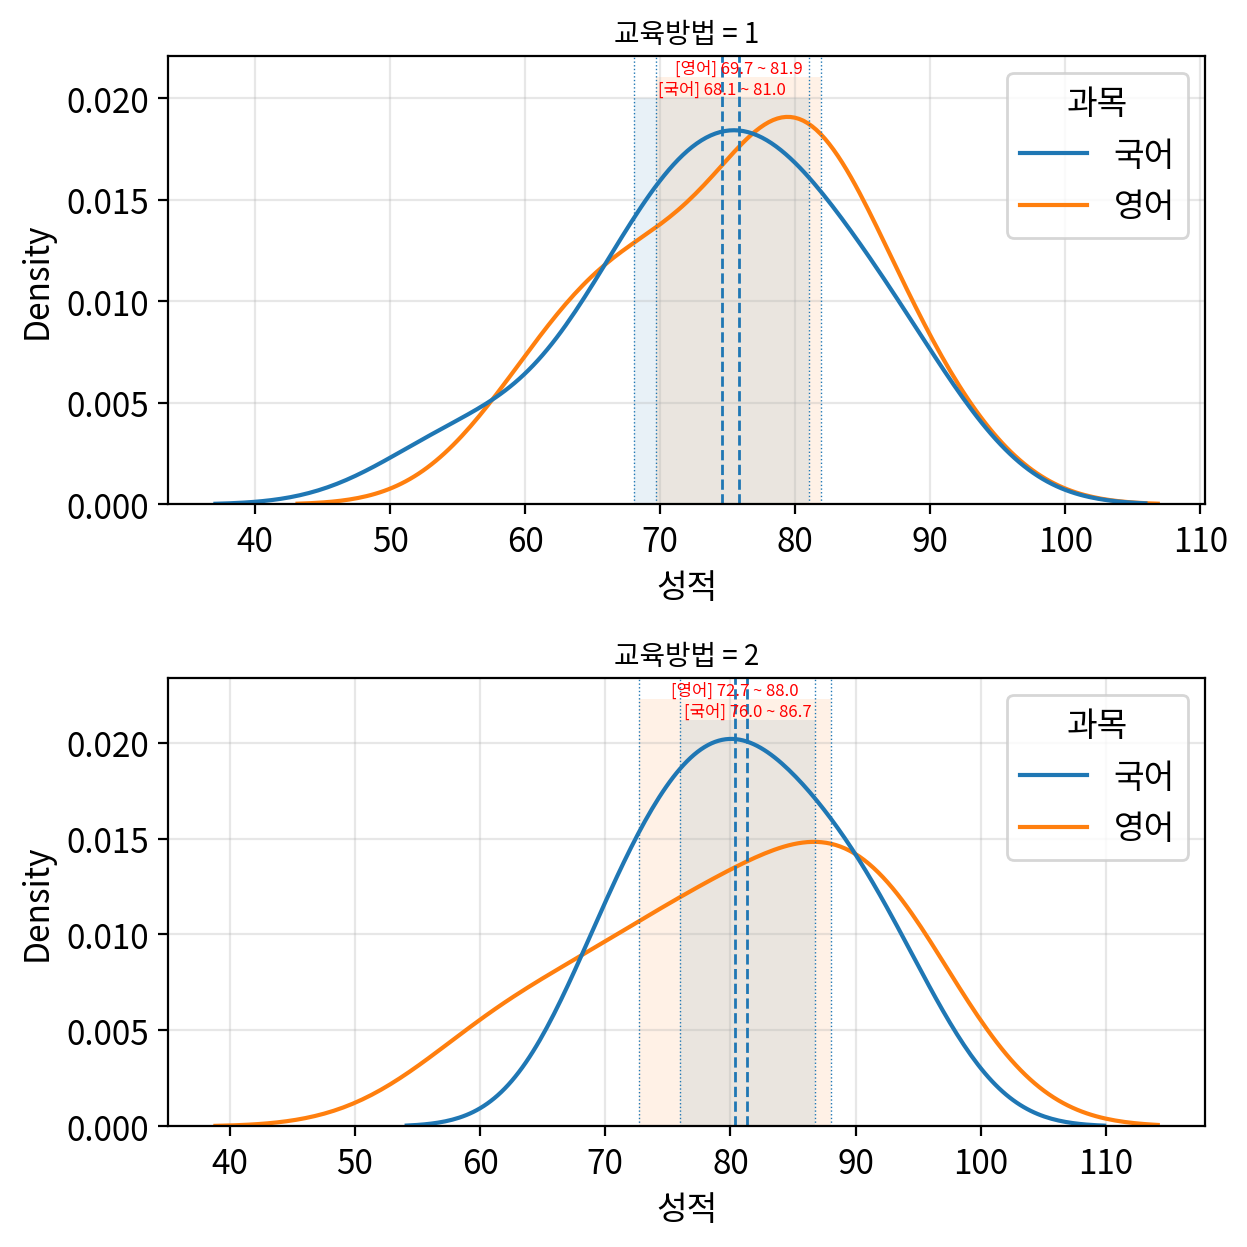

In [19]:
# 확인할 데이터 필드 (수치형):
field = '성적'
# 범주형 필드1:
group_field = '교육방법'
# 범주형 필드2 (hue):
hue_field = '과목'

# 시각화 할 필드만 원본데이터에서 추출:
data = df[[field, group_field, hue_field]]

group_values = data[group_field].unique()
group_count = len(group_values)

hue_values = data[hue_field].unique()

# 1) 그래프 초기화: 캔버스(fig), 도화지(ax) 준비
rows = group_count             # 그래프 행 수
cols = 1                       # 그래프 열 수
width_px = 1280 * cols         # 그래프 가로 크기
height_px = 640 * rows         # 그래프 세로 크기
figsize = (width_px / my_dpi, height_px / my_dpi)

# ax 객체가 행, 열 수에 따라 리스트 됨:
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기:
for i, v in enumerate(group_values):
    temp = data[data[group_field] == v]
    #display(temp)

    # 2) KDE plot 그리기:
    sb.kdeplot(data=temp, x=field, hue=hue_field, ax = ax[i])
    ax[i].grid(True, alpha=0.3)
    ax[i].set_title("{0} = {1}".format(group_field, v), 
                    fontsize=10, pad=5)
    
    for h in hue_values:
        temp_sub = temp[temp[hue_field] == h]

        # 신뢰구간 변수 설정:
        max = temp_sub[field].max()                    # 최대값
        dof = len(temp_sub[field]) - 1                 # 자유도
        clevel = 0.95                                  # 신뢰수준
        sp_mean = temp_sub[field].mean()               # 표본평균
        sp_std = temp_sub[field].std(ddof=1)           # 표본표준편차
        sp_std_error = sp_std / sqrt(len(temp_sub[field]))# 표본표준오차

        cmin, cmax = t.interval(clevel, dof, loc = sp_mean, scale = sp_std_error)

        ax[i].axvline(cmin, linestyle=":", linewidth=0.5) # cmin 경계선
        ax[i].axvline(cmax, linestyle=":", linewidth=0.5) # cmax 경계선

        # 신뢰구간 y값, 평균표시:
        ymin, ymax = ax[i].get_ylim()
        ax[i].fill_between([cmin, cmax], 0, ymax, alpha=0.1)
        ax[i].axvline(sp_mean, linestyle='--', linewidth=1)

        # 텍스트 그리기 (statAnnotator 기능):
        ax[i].text(x = cmin + (cmax-cmin)/2,
                y=ymax,
                s="[%s] %0.1f ~ %0.1f" % (h, cmin, cmax),
                horizontalalignment = "center",
                verticalalignment = "bottom",
                fontdict = {"size": 6, "color": "red"})

# 4) 출력:
plt.tight_layout()           # 여백 제거
plt.show()                   # 그래프 화면 출력
plt.close()                  # 그래프 작업 종료

In [20]:
data = df.copy()
xname = ['교육방법', '과목']  # 범주형 독립변수 2개
yname = '성적'          # 수치형 종속변수 1개

u1 = data[xname[0]].unique() # 명목형변수1의 수준들 종류
u2 = data[xname[1]].unique() # 명목형변수2의 수준들 종류
equal_var_fields = []        # 충족한 등분산성 조건 저장용 
normal_dist = True
report = []

for i in u1:
    for j in u2:
        filtered_data = data[(data[xname[0]] == i) & (data[xname[1]] == j)][yname]
        equal_var_fields.append(filtered_data)
        s, p = normaltest(filtered_data)

        normalize = p > 0.05
        report.append({
            "fields": "{0}, {1}".format(i, j),
            "statistic": s,
            "p-value": p,
            "result": normalize
        })
        normal_dist = normal_dist and normalize

# 등분산성 검정법 선택:
if normal_dist:
    n = "Bartlett" # : 정규성 충족할 때
    s, p = bartlett(*equal_var_fields) # 모든 컬럼의 데이터 한번에
else:
    n = "Levene's" # :정규성 충족 못할 때
    s, p = levene(*equal_var_fields, 
                        center='median')
    # : 정규성 충족 못할 땐 '기본값인 평균'으로 계산하면 안됨

equal_var = p > 0.05

report.append({
    "fields": n,
    "statistic": s,
    "p-value": p,
    "result": equal_var
})

report_df = DataFrame(report).set_index('fields')
report_df

,statistic,p-value,result
fields,,,
"1, 국어",0.911351,0.634020,True
"1, 영어",0.389198,0.823165,True
"2, 국어",0.299661,0.860854,True
"2, 영어",1.094669,0.578490,True
Bartlett,2.871293,0.411898,True


In [21]:
xname = ['교육방법', '과목']
yname = '성적'
data = df[xname + [yname]]

if equal_var:
    pg_anova = anova(data=data, dv=yname, between=xname)
else:
    pg_anova = welch_anova(data=data, dv=yname, between=xname)
display(pg_anova)

for idx in pg_anova.index:
    row = pg_anova.iloc[idx]
    source = row['Source']
    p_val = row['p-unc']

    if p_val <= 0.05:
        print(f"→ {source}효과는 유의함. (대립가설 채택: p ≤ 0.05)")
    else:
        print(f"→ {source}효과는 유의하지 않음. (귀무가설 채택: p > 0.05)")

,Source,SS,DF,MS,F,p-unc,np2
0,교육방법,355.113636,1,355.113636,3.845870,0.056857,0.087713
1,과목,0.204545,1,0.204545,0.002215,0.962695,0.000055
2,교육방법 * 과목,14.204545,1,14.204545,0.153835,0.696979,0.003831
3,Residual,3693.454545,40,92.336364,NaN,NaN,NaN


→ 교육방법효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ 과목효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ 교육방법 * 과목효과는 유의하지 않음. (귀무가설 채택: p > 0.05)
→ Residual효과는 유의하지 않음. (귀무가설 채택: p > 0.05)


In [22]:
xname = ['교육방법', '과목']  # 명목형 독립변수 2개
yname = '성적'          # 수치형 종속변수 1개
data = df[xname + [yname]]

levels = {}           # 빈 딕셔너리 만들기
# 예: {'water': 2, 'sun': 3} 이런 식의 결과 만들기 위해:
for factor in xname:                     # 명목변수 하나씩 꺼냄
    level_count = data[factor].nunique()# 꺼낸 변수의 수준 수 계산
    levels[factor] = level_count         # 딕셔너리에 저장

pvals = {}            # 빈 딕셔너리 만들기
# 예: {'water': 1.3e-20, 'sun': 2.01e-17, 'water*sun': 0.105}:
for index, row in pg_anova.iterrows():  # 행 하나씩 꺼냄
    source_name = row['Source']         # 명목변수 이름
    p_value = row['p-unc']              # 각 명목변수의 p-value
    pvals[source_name] = p_value        # 딕셔너리에 저장

for factor in xname:
    print(f"\n[{factor}]")

    if levels[factor] <= 2:
        print(f"- {levels[factor]}수준 요인이므로 사후검정이 필요 없습니다.")
        continue

    p_val = pvals.get(factor, None)
    if p_val is None:
        print("- ANOVA 결과에서 해당 요인을 찾을 수 없습니다.")
        continue

    if p_val > 0.05:
        print(f"- 주효과 유의하지 않음 (p={p_val:.3g}) → 사후검정 수행 안함")
        continue

    print(f"- 주효과 유의함 (p={p_val:.3g}) → 사후검정 수행")

    # 결론: hue 그룹 간 평균값 끼리는 유의미한 차이 있다
    # 얼마나? -> 사후검정 ㄱㄱ
    if equal_var:
        print(" · Tukey HSD 사용 (등분산 충족)")
        hoc_df = pairwise_tukey(data=data, dv=yname, between=factor)
    else:
        print(" · Games-Howell 사용 (등분산 불충족)")
        hoc_df = pairwise_gameshowell(data=data, dv=yname, between=factor)

    display(hoc_df)

# 상호작용 자동 처리:
interaction_names = [src for src in pvals.keys() if '*' in src]

for inter in interaction_names:
    p_val = pvals[inter]
    print(f"\n[{inter}] 상호작용 효과")

    if p_val <= 0.05:
        print(f"- 상호작용 유의함 (p={p_val:.3g}) → 단순주효과 분석 필요")
    else:
        print(f"- 상호작용 유의하지 않음 (p={p_val:.3g}) → 단순주효과 분석 불필요")


[교육방법]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[과목]
- 2수준 요인이므로 사후검정이 필요 없습니다.

[교육방법 * 과목] 상호작용 효과
- 상호작용 유의하지 않음 (p=0.697) → 단순주효과 분석 불필요
